Processando iris/direito.png...


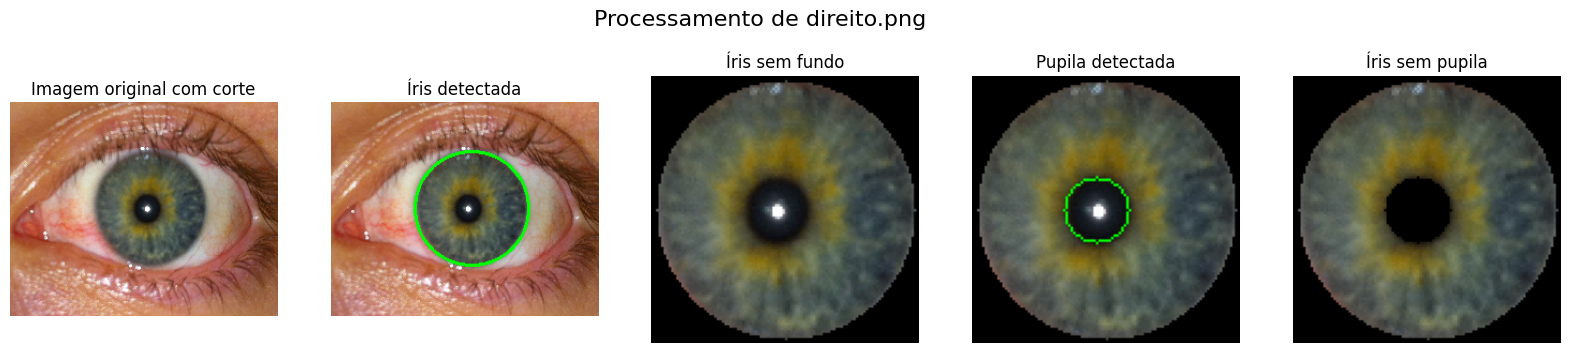

Processando iris/esquerdo.png...


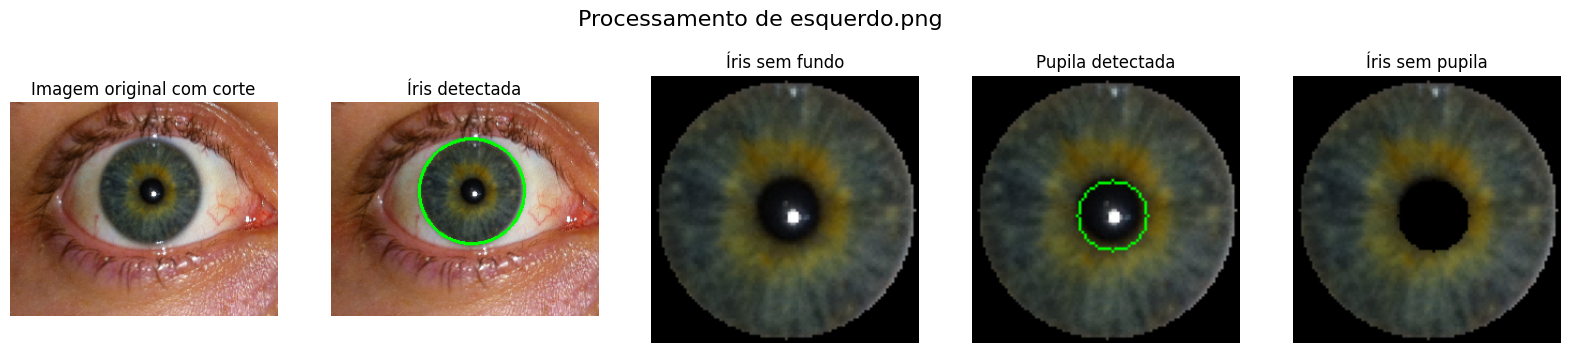

In [52]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def prepara_imagem(caminho):
    imagem = cv2.imread(caminho)
    altura, largura, _ = imagem.shape
    x_inicio = largura // 3
    y_inicio = altura // 3
    x_fim = largura - largura // 3
    y_fim = altura - altura // 3
    olho_cortado = cv2.resize(imagem[y_inicio:y_fim, x_inicio:x_fim], (250, 200))
    return olho_cortado, largura, altura

def prepara_iris(olho_cortado, largura, altura):
    olho_cinza = cv2.cvtColor(olho_cortado, cv2.COLOR_BGR2GRAY)
    olho_suavizado = cv2.GaussianBlur(olho_cinza, (9, 9), 2)
    bordas = cv2.Canny(olho_suavizado, 60, 100)
    circulos = cv2.HoughCircles(bordas, cv2.HOUGH_GRADIENT, dp=2, minDist=60, param1=60, param2=60, minRadius=40, maxRadius=70)
    olho_circulado = olho_cortado.copy()
    iris_sem_fundo = None
    if circulos is not None:
        circulos = np.round(circulos[0, :]).astype("int")
        for (x, y, raio) in circulos:
            cv2.circle(olho_circulado, (x, y), raio, (0, 255, 0), 2)
            x_inicio_circulo = max(x - raio, 0)
            y_inicio_circulo = max(y - raio, 0)
            x_fim_circulo = min(x + raio, largura - 1)
            y_fim_circulo = min(y + raio, altura - 1)
            iris_recortada = olho_cortado[y_inicio_circulo:y_fim_circulo, x_inicio_circulo:x_fim_circulo]
            mascara_iris = np.zeros(iris_recortada.shape[:2], dtype=np.uint8)
            cv2.circle(mascara_iris, (raio, raio), raio-2, (255), -1)
            iris_sem_fundo = cv2.bitwise_and(iris_recortada, iris_recortada, mask=mascara_iris)
    return olho_circulado, iris_sem_fundo

def prepara_pupila(iris_sem_fundo):
    iris_cinza = cv2.cvtColor(iris_sem_fundo, cv2.COLOR_BGR2GRAY)
    iris_suavizada = cv2.GaussianBlur(iris_cinza, (9, 9), 2)
    bordas_iris = cv2.Canny(iris_suavizada, 60, 100)
    circulos_pupila = cv2.HoughCircles(bordas_iris, cv2.HOUGH_GRADIENT, dp=2, minDist=30, param1=60, param2=40, minRadius=10, maxRadius=20)
    pupila_circulada = iris_sem_fundo.copy()
    if circulos_pupila is not None:
        circulos_pupila = np.round(circulos_pupila[0, :]).astype("int")
        for (x_pupila, y_pupila, raio_pupila) in circulos_pupila:
            cv2.circle(pupila_circulada, (x_pupila, y_pupila), raio_pupila, (0, 255, 0), 1)
            mascara_pupila = np.zeros(iris_sem_fundo.shape[:2], dtype=np.uint8)
            cv2.circle(mascara_pupila, (x_pupila, y_pupila), raio_pupila, (255), -1)
            iris_sem_pupila = cv2.bitwise_and(iris_sem_fundo, iris_sem_fundo, mask=cv2.bitwise_not(mascara_pupila))
    else:
        iris_sem_pupila = iris_sem_fundo
    return pupila_circulada, iris_sem_pupila

def executaPrograma(dir):
  titulos = ["Imagem original com corte", "Íris detectada", "Íris sem fundo", "Pupila detectada", "Íris sem pupila"]

  for arquivo in os.listdir(dir):
      if arquivo.endswith('.jpg') or arquivo.endswith('.png'):
          caminho_arquivo = os.path.join(dir, arquivo)
          print(f"Processando {caminho_arquivo}...")

          olho_cortado, largura, altura = prepara_imagem(caminho_arquivo)
          imagem_circulada, imagem_sem_fundo = prepara_iris(olho_cortado, largura, altura)
          pupila_circulada, iris_sem_pupila = prepara_pupila(imagem_sem_fundo)

          imagens = [olho_cortado, imagem_circulada, imagem_sem_fundo, pupila_circulada, iris_sem_pupila]

          fig, axes = plt.subplots(1, 5, figsize=(20, 4))
          fig.suptitle(f'Processamento de {arquivo}', fontsize=16)

          for ax, img, titulo in zip(axes, imagens, titulos):
              if img is not None:
                  ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
              ax.set_title(titulo)
              ax.axis('off')

          plt.subplots_adjust(top=0.85)
          plt.show()

executaPrograma("iris/")